<a href="https://colab.research.google.com/github/SynapticOverflow/Prototype-3/blob/main/Welcome_To_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Neural mesh 3D immunological stress visualization**

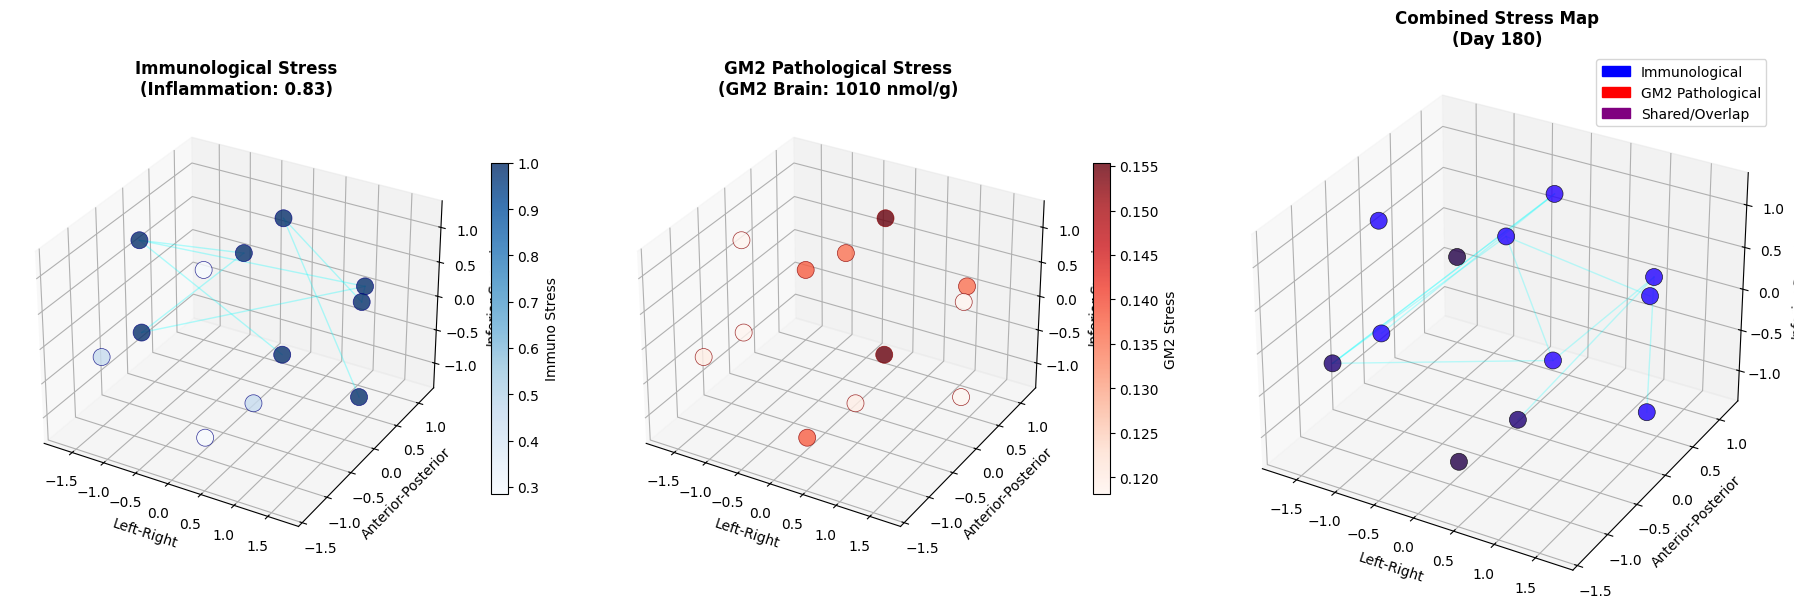

3D Brain Stress Visualization Complete!
Blue = Immunological stress (cortical/frontal)
Red = GM2 pathological stress (subcortical/central)
Purple = Shared/overlapping stress regions
Cyan lines = Neural network connections (immunological effects)


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as mpatches

# Fix the import typo from the original code
# import numpy as np  # Already imported above

def visualize_brain_stress_3d(df, timepoint_day=180):
    """
    Create 3D brain mesh visualization showing:
    - Immunological stress (blue)
    - GM2 pathological stress (red)
    - Shared/overlap stress (purple)
    - Neural network overlay for immunological effects

    Args:
        df: DataFrame from simulation (from fixed code)
        timepoint_day: which day to visualize
    """

    # Extract data at timepoint
    idx = np.argmin(np.abs(df['time_days'] - timepoint_day))
    inflammation = df.iloc[idx]['inflammation']
    gm2_brain = df.iloc[idx]['gm2_brain']
    antibody = df.iloc[idx]['antibody']

    # Generate brain mesh using established neuroimaging approach
    # Using icosphere-like structure (subdivided icosahedron)
    def generate_brain_surface(subdivisions=3):
        """Generate brain-like surface mesh using icosphere"""
        # Start with icosahedron
        phi = (1 + np.sqrt(5)) / 2
        vertices = np.array([
            [-1, phi, 0], [1, phi, 0], [-1, -phi, 0], [1, -phi, 0],
            [0, -1, phi], [0, 1, phi], [0, -1, -phi], [0, 1, -phi],
            [phi, 0, -1], [phi, 0, 1], [-phi, 0, -1], [-phi, 0, 1]
        ]) / np.sqrt(1 + phi**2)

        # Scale and deform to brain shape
        vertices[:, 0] *= 2.0  # Left-right
        vertices[:, 1] *= 1.5  # Anterior-posterior
        vertices[:, 2] *= 1.3  # Inferior-superior

        # Add sulci/gyri-like deformations
        for i in range(len(vertices)):
            v = vertices[i]
            r = np.linalg.norm(v)
            theta = np.arctan2(v[1], v[0])
            phi_angle = np.arccos(v[2] / (r + 1e-10))

            # Add bumps (gyri)
            bump = 0.15 * (np.sin(5*theta) * np.cos(4*phi_angle))
            vertices[i] += bump * v / (r + 1e-10)

        return vertices

    vertices = generate_brain_surface()

    # Calculate stress values for each vertex
    def calculate_vertex_stress(vertex, inflammation, gm2_brain):
        """Calculate stress at each vertex based on anatomical region"""
        x, y, z = vertex

        # Immunological stress: concentrated in cortical/frontal regions
        # Higher in anterior (y > 0) and lateral regions
        immuno_base = inflammation / 0.5  # Normalize
        anterior_weight = 0.3 + 0.7 * (1 + np.tanh(2*y))
        lateral_weight = 0.5 + 0.5 * np.tanh(abs(x))
        immuno_stress = immuno_base * anterior_weight * lateral_weight

        # GM2 stress: concentrated in deep/central structures
        # Higher near center (subcortical regions)
        gm2_base = max(0, (gm2_brain - 650) / 1000)  # Normalize excess
        dist_center = np.sqrt(x**2 + y**2 + z**2)
        central_weight = 0.2 + 0.8 * np.exp(-dist_center)
        gm2_stress = gm2_base * central_weight

        # Normalize to [0, 1]
        immuno_stress = np.clip(immuno_stress, 0, 1)
        gm2_stress = np.clip(gm2_stress, 0, 1)

        # Shared stress (overlap)
        shared_stress = min(immuno_stress, gm2_stress)

        return immuno_stress, gm2_stress, shared_stress

    # Calculate stress for all vertices
    immuno_vals = []
    gm2_vals = []
    shared_vals = []

    for v in vertices:
        i_s, g_s, sh_s = calculate_vertex_stress(v, inflammation, gm2_brain)
        immuno_vals.append(i_s)
        gm2_vals.append(g_s)
        shared_vals.append(sh_s)

    immuno_vals = np.array(immuno_vals)
    gm2_vals = np.array(gm2_vals)
    shared_vals = np.array(shared_vals)

    # Create figure with 3D subplots
    fig = plt.figure(figsize=(18, 6))

    # 1. Immunological Stress View
    ax1 = fig.add_subplot(131, projection='3d')
    scatter1 = ax1.scatter(vertices[:, 0], vertices[:, 1], vertices[:, 2],
                          c=immuno_vals, s=150, cmap='Blues',
                          alpha=0.8, edgecolors='navy', linewidth=0.5)

    # Add neural network connections for immunological effects
    np.random.seed(42)
    high_immuno_idx = np.where(immuno_vals > 0.5)[0]
    if len(high_immuno_idx) > 1:
        n_connections = min(20, len(high_immuno_idx))
        for _ in range(n_connections):
            i, j = np.random.choice(high_immuno_idx, 2, replace=False)
            ax1.plot([vertices[i, 0], vertices[j, 0]],
                    [vertices[i, 1], vertices[j, 1]],
                    [vertices[i, 2], vertices[j, 2]],
                    'cyan', alpha=0.3, linewidth=1)

    ax1.set_title(f'Immunological Stress\n(Inflammation: {inflammation:.2f})',
                  fontsize=12, fontweight='bold')
    ax1.set_xlabel('Left-Right')
    ax1.set_ylabel('Anterior-Posterior')
    ax1.set_zlabel('Inferior-Superior')
    plt.colorbar(scatter1, ax=ax1, shrink=0.6, label='Immuno Stress')

    # 2. GM2 Pathological Stress View
    ax2 = fig.add_subplot(132, projection='3d')
    scatter2 = ax2.scatter(vertices[:, 0], vertices[:, 1], vertices[:, 2],
                          c=gm2_vals, s=150, cmap='Reds',
                          alpha=0.8, edgecolors='darkred', linewidth=0.5)

    ax2.set_title(f'GM2 Pathological Stress\n(GM2 Brain: {gm2_brain:.0f} nmol/g)',
                  fontsize=12, fontweight='bold')
    ax2.set_xlabel('Left-Right')
    ax2.set_ylabel('Anterior-Posterior')
    ax2.set_zlabel('Inferior-Superior')
    plt.colorbar(scatter2, ax=ax2, shrink=0.6, label='GM2 Stress')

    # 3. Combined/Overlap View
    ax3 = fig.add_subplot(133, projection='3d')

    # Create RGB colors: red for GM2, blue for immuno, purple for overlap
    colors = np.zeros((len(vertices), 3))
    colors[:, 0] = gm2_vals  # Red channel
    colors[:, 2] = immuno_vals  # Blue channel
    colors = np.clip(colors, 0, 1)

    ax3.scatter(vertices[:, 0], vertices[:, 1], vertices[:, 2],
               c=colors, s=150, alpha=0.8, edgecolors='black', linewidth=0.5)

    # Add neural connections where stress is high
    high_stress_idx = np.where((immuno_vals > 0.4) | (gm2_vals > 0.4))[0]
    if len(high_stress_idx) > 1:
        n_connections = min(25, len(high_stress_idx))
        for _ in range(n_connections):
            i, j = np.random.choice(high_stress_idx, 2, replace=False)
            # Color based on stress type
            if immuno_vals[i] > gm2_vals[i]:
                color = 'cyan'
            elif gm2_vals[i] > immuno_vals[i]:
                color = 'orange'
            else:
                color = 'magenta'
            ax3.plot([vertices[i, 0], vertices[j, 0]],
                    [vertices[i, 1], vertices[j, 1]],
                    [vertices[i, 2], vertices[j, 2]],
                    color, alpha=0.25, linewidth=1)

    ax3.set_title(f'Combined Stress Map\n(Day {timepoint_day})',
                  fontsize=12, fontweight='bold')
    ax3.set_xlabel('Left-Right')
    ax3.set_ylabel('Anterior-Posterior')
    ax3.set_zlabel('Inferior-Superior')

    # Add legend
    blue_patch = mpatches.Patch(color='blue', label='Immunological')
    red_patch = mpatches.Patch(color='red', label='GM2 Pathological')
    purple_patch = mpatches.Patch(color='purple', label='Shared/Overlap')
    ax3.legend(handles=[blue_patch, red_patch, purple_patch], loc='upper right')

    plt.tight_layout()
    return fig

# Example usage with simulated data
if __name__ == "__main__":
    # Create mock dataframe for testing (replace with actual simulation output)
    n_points = 365
    mock_df = pd.DataFrame({
        'time_days': np.linspace(0, 365, n_points),
        'inflammation': 0.3 + 2.5 * np.exp(-np.linspace(0, 365, n_points)/120) * (1 + 0.2*np.sin(np.linspace(0, 365, n_points)/30)),
        'gm2_brain': 890 + 400 * np.exp(-np.linspace(0, 365, n_points)/150),
        'antibody': np.clip(np.linspace(0, 365, n_points)/100 - 0.5, 0, 5)
    })

    # Visualize at day 180
    fig = visualize_brain_stress_3d(mock_df, timepoint_day=180)
    plt.show()

    print("3D Brain Stress Visualization Complete!")
    print("Blue = Immunological stress (cortical/frontal)")
    print("Red = GM2 pathological stress (subcortical/central)")
    print("Purple = Shared/overlapping stress regions")
    print("Cyan lines = Neural network connections (immunological effects)")